In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import tanh
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from nltk.sentiment import SentimentIntensityAnalyzer
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Books_rating.csv')

In [ ]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [ ]:
df.isnull().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561886
review/helpfulness          0
review/score                0
review/time                 0
review/summary             38
review/text                 8
dtype: int64

In [ ]:
df.describe()

,Price,review/score,review/time
count,481171.000000,3.000000e+06,3.000000e+06
mean,21.762656,4.215289e+00,1.132307e+09
std,26.206541,1.203054e+00,1.493202e+08
min,1.000000,1.000000e+00,-1.000000e+00
25%,10.780000,4.000000e+00,9.999072e+08
50%,14.930000,5.000000e+00,1.128298e+09
75%,23.950000,5.000000e+00,1.269130e+09
max,995.000000,5.000000e+00,1.362355e+09


**Data Visualization**

Text(0.5, 1.0, 'Distribution of Book Prices')

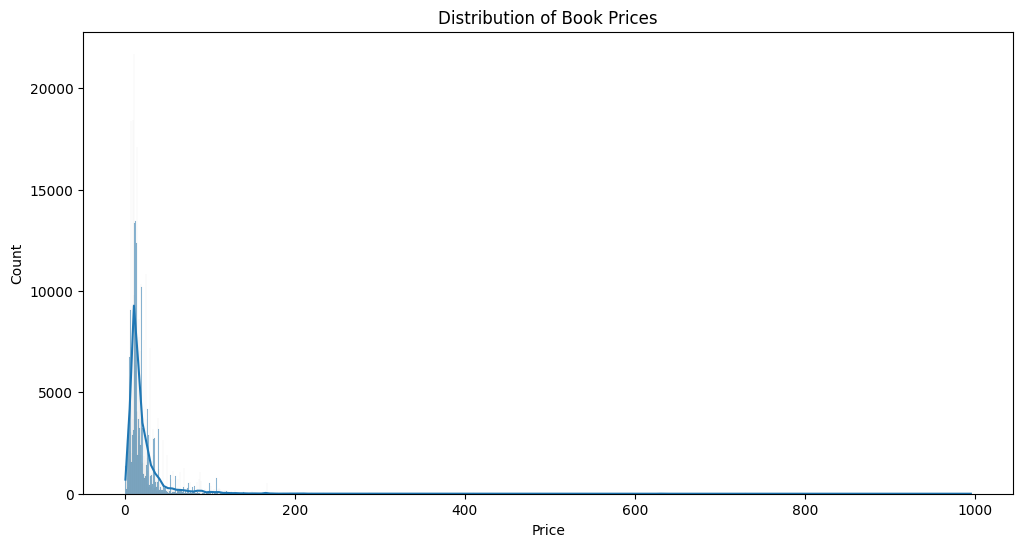

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Book Prices')

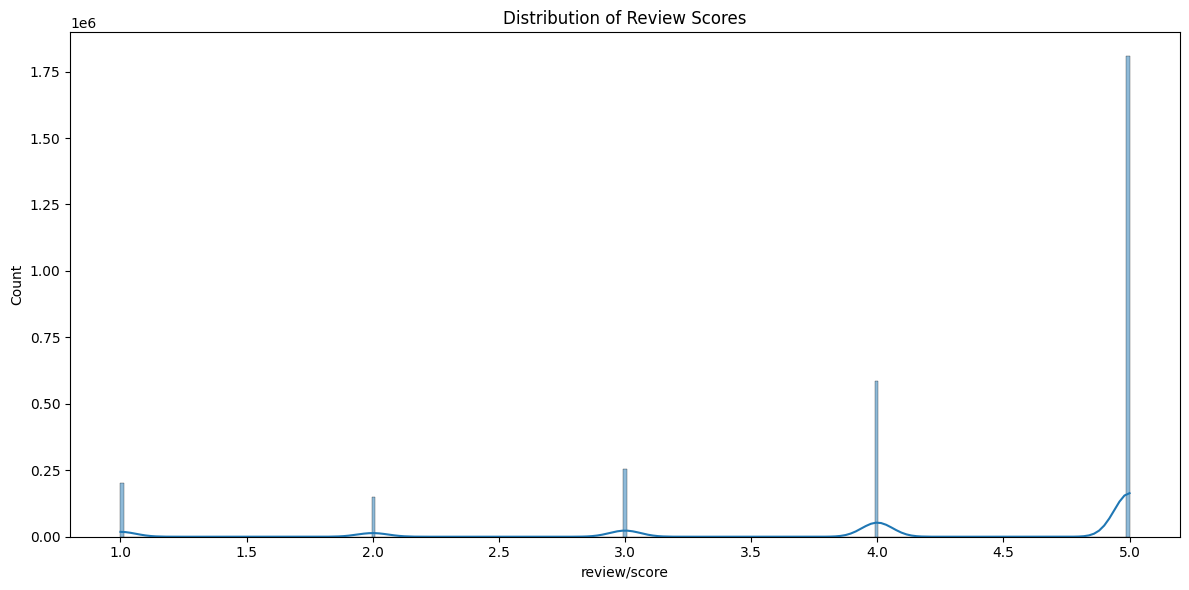

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['review/score'], kde=True)
plt.title('Distribution of Review Scores')
plt.tight_layout()
plt.show()

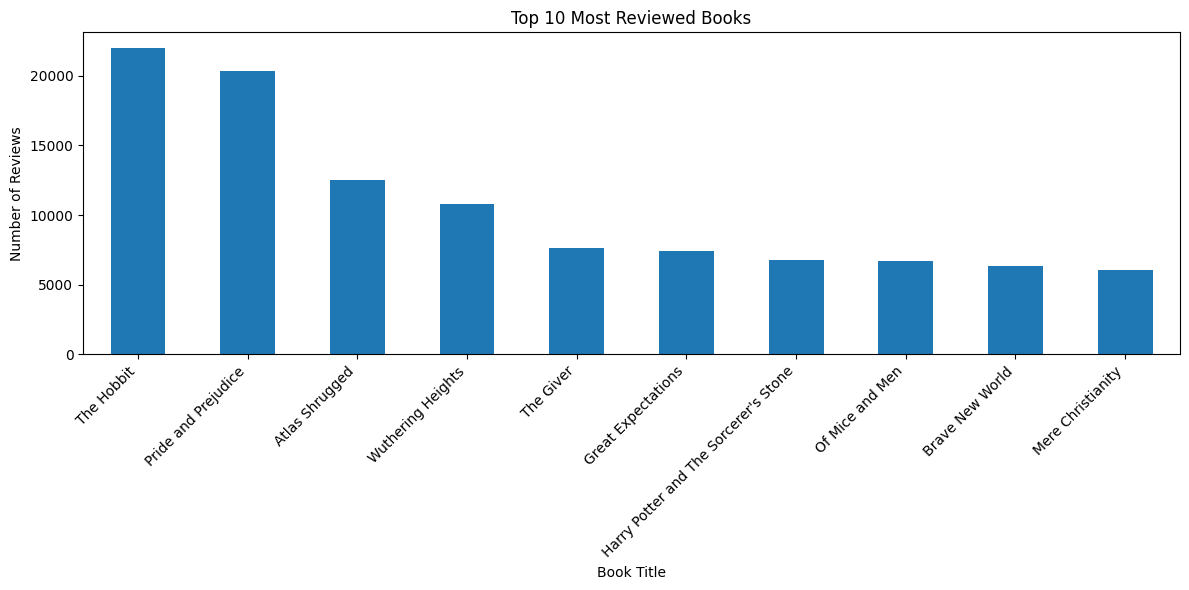

In [ ]:
plt.figure(figsize=(12, 6))
top_titles = df['Title'].value_counts().head(10)
top_titles.plot(kind='bar')
plt.title('Top 10 Most Reviewed Books')
plt.xlabel('Book Title')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

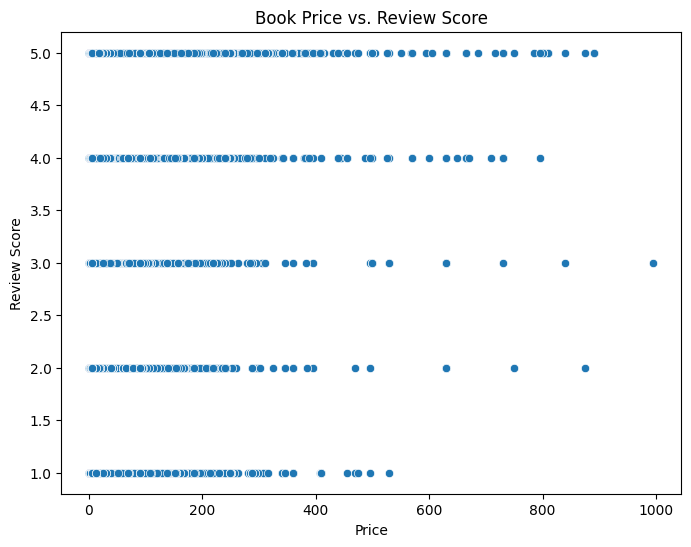

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='review/score', data=df)
plt.title('Book Price vs. Review Score')
plt.xlabel('Price')
plt.ylabel('Review Score')
plt.show()

In [ ]:
numerical_columns = ['Price', 'review/score','review/time']
numerical_df = df[numerical_columns]
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

                 Price  review/score  review/time
Price         1.000000     -0.010510    -0.030341
review/score -0.010510      1.000000     0.008036
review/time  -0.030341      0.008036     1.000000


**Handling Outliers**

<Axes: xlabel='review/score'>

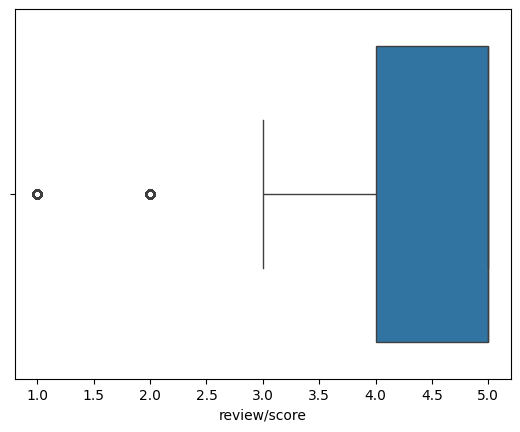

In [ ]:
sns.boxplot(x = 'review/score', data = df)

In [ ]:
df['review/score'].quantile(0.12)

3.0

<Axes: xlabel='review/score'>

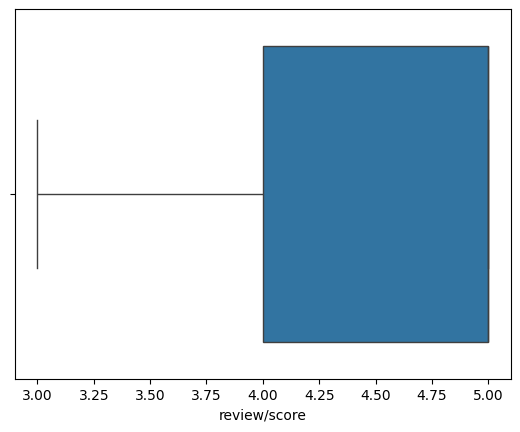

In [ ]:
df['review/score'] = np.where(df['review/score'] < 3, 3, df['review/score'])
sns.boxplot(x = 'review/score', data = df)

<Axes: xlabel='review/time'>

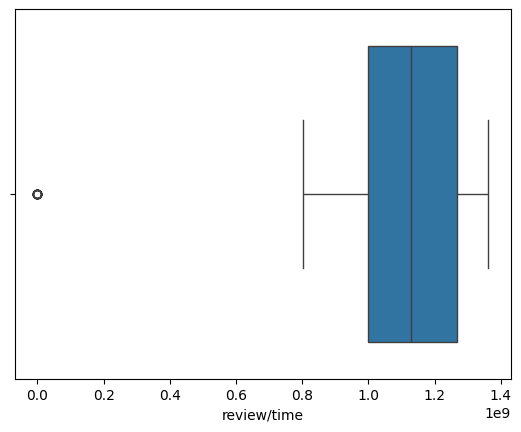

In [ ]:
sns.boxplot(x = 'review/time', data = df)

In [ ]:
df['review/time'].quantile(0.03)

897609600.0

<Axes: xlabel='review/time'>

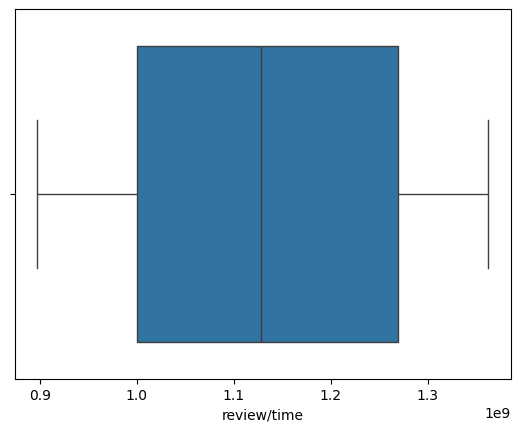

In [ ]:
df['review/time'] = np.where(df['review/time'] < 897609600.0, 897609600.0, df['review/time'])
sns.boxplot(x = 'review/time', data = df)

**Handling Missing Values**

In [ ]:
total_rows = len(df)
missing_values = df['Price'].isnull().sum()
percentage_missing = (missing_values / total_rows) * 100
print("Percentage of missing values in the 'Price' column:", percentage_missing)

Percentage of missing values in the 'Price' column: 83.96096666666666


In [ ]:
df.drop(columns=['Price'], inplace=True)

In [ ]:
df.isnull().sum()

Id                         0
Title                    208
User_id               561787
profileName           561886
review/helpfulness         0
review/score               0
review/time                0
review/summary            38
review/text                8
dtype: int64

In [ ]:
object_cols = ['Title', 'User_id', 'profileName', 'review/summary', 'review/text']

for col in object_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [ ]:
df.isnull().sum()

Id                    0
Title                 0
User_id               0
profileName           0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64

**Handling Categorical Features**

In [ ]:
df.head()

,Id,Title,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,9.406368e+08,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1.095725e+09,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1.078790e+09,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1.090714e+09,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1.107994e+09,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [ ]:
label_encoder = LabelEncoder()
df['Id'] = label_encoder.fit_transform(df['Id'])

In [ ]:
df = df.drop(['review/time'], axis = 1)
df = df.drop(['profileName'], axis = 1)
df = df.drop(['User_id'], axis = 1)
df = df.drop(['review/text'],axis = 1)
df = df.drop(['Title'],axis = 1)
df

,Id,review/helpfulness,review/score,review/summary
0,130707,7/7,4.0,Nice collection of Julie Strain images
1,74269,10/10,5.0,Really Enjoyed It
2,74269,10/11,5.0,Essential for every personal and Public Library
3,74269,7/7,4.0,Phlip Nel gives silly Seuss a serious treatment
4,74269,3/3,4.0,Good academic overview
...,...,...,...,...
2999995,210845,14/19,4.0,Difficult
2999996,210845,1/1,4.0,Quite good and ahead of its time occasionally
2999997,210845,0/0,4.0,Easier reads of those not well versed in histo...
2999998,210845,1/11,5.0,"Yes, it is cheaper than the University Bookstore"


In [ ]:
def fraction_to_percentage(fraction):
    numerator, denominator = map(int, fraction.split('/'))
    if(denominator == 0):
        return 0
    else:
        return (numerator / denominator) * 100

In [ ]:
df['review/helpfulness'] = df['review/helpfulness'].apply(fraction_to_percentage)
df['review/helpfulness'] = df['review/helpfulness'].astype(int)

In [ ]:
df['review/summary'].fillna("No Review", inplace=True)
df['review/summary'].isnull().sum()

0

In [ ]:
sentences = df['review/summary']

In [ ]:
print(df['review/summary'].dtype)

object


In [ ]:
print(sentences)

0                     Nice collection of Julie Strain images
1                                          Really Enjoyed It
2            Essential for every personal and Public Library
3            Phlip Nel gives silly Seuss a serious treatment
4                                     Good academic overview
                                 ...                        
2999995                                            Difficult
2999996        Quite good and ahead of its time occasionally
2999997    Easier reads of those not well versed in histo...
2999998     Yes, it is cheaper than the University Bookstore
2999999    Collingwood's ideas sink in a quagmire or verb...
Name: review/summary, Length: 3000000, dtype: object


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_scores = [sentiment_analyzer.polarity_scores(sentence)['compound'] for sentence in sentences]

In [ ]:
df['sentiment_scores'] = sentiment_scores

In [ ]:
df['sentiment_scores'].isnull().sum()

0

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['review/summary'])

In [ ]:
average_scores = []
for i in tqdm(range(len(df))):
    sentence = df['review/summary'].iloc[i]
    tfidf_indices = [tfidf_vectorizer.vocabulary_[word] for word in sentence.split() if word in tfidf_vectorizer.vocabulary_]
    tfidf_scores = X_tfidf[i, tfidf_indices].toarray().flatten()
    average_score = np.mean(tfidf_scores)
    average_scores.append(average_score)

  0%|          | 0/3000000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 3000000/3000000 [19:13<00:00, 2600.85it/s]


In [ ]:
df['average_tfidf_score'] = average_scores

In [ ]:
df['average_tfidf_score'] = df['average_tfidf_score'].fillna(0.1)

In [ ]:
df['average_tfidf_score'].isnull().sum()

0

In [ ]:
df

,Id,review/helpfulness,review/score,review/summary,sentiment_scores,average_tfidf_score
0,130707,100,4.0,Nice collection of Julie Strain images,0.3818,0.321476
1,74269,100,5.0,Really Enjoyed It,0.5563,0.100000
2,74269,90,5.0,Essential for every personal and Public Library,0.0000,0.299751
3,74269,100,4.0,Phlip Nel gives silly Seuss a serious treatment,-0.0516,0.290672
4,74269,100,4.0,Good academic overview,0.4404,0.667842
...,...,...,...,...,...,...
2999995,210845,73,4.0,Difficult,-0.3612,0.100000
2999996,210845,100,4.0,Quite good and ahead of its time occasionally,0.4927,0.318652
2999997,210845,0,4.0,Easier reads of those not well versed in histo...,0.2467,0.292694
2999998,210845,9,5.0,"Yes, it is cheaper than the University Bookstore",0.4019,0.246968


In [ ]:
print(X_tfidf)

  (0, 59170)	0.4638928435588567
  (0, 114559)	0.545068787450919
  (0, 64868)	0.4912488590334693
  (0, 84709)	0.15251142467987033
  (0, 24397)	0.3480246309620461
  (0, 82475)	0.31936989013653955
  (1, 63046)	0.3807264137556986
  (1, 39428)	0.7220590840282494
  (1, 98279)	0.5776487488439754
  (2, 69871)	0.4247811587646249
  (2, 95679)	0.5031760792457854
  (2, 6318)	0.19353795009390362
  (2, 89763)	0.4273313205673145
  (2, 41292)	0.3719164782391286
  (2, 46248)	0.2062174940227622
  (2, 40729)	0.4067656366290572
  (3, 122608)	0.30621521112309946
  (3, 107020)	0.2640060041927818
  (3, 107182)	0.3405701545936893
  (3, 109068)	0.29902854435457416
  (3, 50078)	0.29343800245462004
  (3, 81905)	0.5220254363551904
  (3, 90438)	0.5220254363551904
  (4, 87024)	0.6018008661732737
  (4, 2837)	0.7338825463783886
  :	:
  (2999996, 84709)	0.1668696862362964
  (2999997, 127969)	0.5309137320000314
  (2999997, 56180)	0.47522477586407863
  (2999997, 98169)	0.340002863803517
  (2999997, 120101)	0.29075192853

In [ ]:
def batch_pad_sequences(sequences, maxlen, batch_size):
    num_samples = sequences.shape[0]  # Use shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    padded_sequences = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)  # Use num_samples
        batch_sequences = sequences[start_idx:end_idx]
        padded_batch = pad_sequences(batch_sequences.toarray(), maxlen=maxlen)  # Convert to dense array
        padded_sequences.extend(padded_batch)
    return np.array(padded_sequences)

In [ ]:
maxlen = 50
batch_size = 32
sequences = X_tfidf

In [ ]:
sequences.shape[0]

3000000

In [ ]:
padded_sequences_batch = batch_pad_sequences(sequences, maxlen=maxlen, batch_size=batch_size)
padded_sequences_batch.shape

(3000000, 50)

In [ ]:
df

,Id,review/helpfulness,review/score,review/summary,sentiment_scores,average_tfidf_score
0,130707,100,4.0,Nice collection of Julie Strain images,0.3818,0.321476
1,74269,100,5.0,Really Enjoyed It,0.5563,0.100000
2,74269,90,5.0,Essential for every personal and Public Library,0.0000,0.299751
3,74269,100,4.0,Phlip Nel gives silly Seuss a serious treatment,-0.0516,0.290672
4,74269,100,4.0,Good academic overview,0.4404,0.667842
...,...,...,...,...,...,...
2999995,210845,73,4.0,Difficult,-0.3612,0.100000
2999996,210845,100,4.0,Quite good and ahead of its time occasionally,0.4927,0.318652
2999997,210845,0,4.0,Easier reads of those not well versed in histo...,0.2467,0.292694
2999998,210845,9,5.0,"Yes, it is cheaper than the University Bookstore",0.4019,0.246968


In [ ]:
df1 = df.drop(['review/score'],axis = 1)
df1

,Id,review/helpfulness,review/summary,sentiment_scores,average_tfidf_score
0,130707,100,Nice collection of Julie Strain images,0.3818,0.321476
1,74269,100,Really Enjoyed It,0.5563,0.100000
2,74269,90,Essential for every personal and Public Library,0.0000,0.299751
3,74269,100,Phlip Nel gives silly Seuss a serious treatment,-0.0516,0.290672
4,74269,100,Good academic overview,0.4404,0.667842
...,...,...,...,...,...
2999995,210845,73,Difficult,-0.3612,0.100000
2999996,210845,100,Quite good and ahead of its time occasionally,0.4927,0.318652
2999997,210845,0,Easier reads of those not well versed in histo...,0.2467,0.292694
2999998,210845,9,"Yes, it is cheaper than the University Bookstore",0.4019,0.246968


In [ ]:
df1 = df1.drop(['review/summary'],axis = 1)
df1

,Id,review/helpfulness,sentiment_scores,average_tfidf_score
0,130707,100,0.3818,0.321476
1,74269,100,0.5563,0.100000
2,74269,90,0.0000,0.299751
3,74269,100,-0.0516,0.290672
4,74269,100,0.4404,0.667842
...,...,...,...,...
2999995,210845,73,-0.3612,0.100000
2999996,210845,100,0.4927,0.318652
2999997,210845,0,0.2467,0.292694
2999998,210845,9,0.4019,0.246968


In [ ]:
concatenated_features = np.concatenate((padded_sequences_batch, df1), axis=1)

In [ ]:
concatenated_features

array([[  0.        ,   0.        ,   0.        , ..., 100.        ,
          0.3818    ,   0.3214763 ],
       [  0.        ,   0.        ,   0.        , ..., 100.        ,
          0.5563    ,   0.1       ],
       [  0.        ,   0.        ,   0.        , ...,  90.        ,
          0.        ,   0.29975081],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.2467    ,   0.29269374],
       [  0.        ,   0.        ,   0.        , ...,   9.        ,
          0.4019    ,   0.24696779],
       [  0.        ,   0.        ,   0.        , ...,  14.        ,
          0.        ,   0.30242006]])

In [ ]:
X = concatenated_features
y = df['review/score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.shape
y_train

484969     3.0
2414434    5.0
340713     3.0
1781932    5.0
1522192    5.0
          ... 
1907384    5.0
1911525    3.0
1676165    3.0
2380492    5.0
445243     4.0
Name: review/score, Length: 2400000, dtype: float64

In [ ]:
input_dim = concatenated_features.shape[1]

In [ ]:
model = Sequential()


model.add(Dense(64, input_dim=input_dim))
model.add(LeakyReLU(0.2))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(LeakyReLU(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(optimizer=Adam(), loss='mse', metrics=[MeanSquaredError()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3520      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5633 (22.00 KB)
Trainable params: 5633 (22

In [ ]:
class LossPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):

        val_loss = self.model.evaluate(self.X_val, self.y_val, verbose=0)


        self.train_losses.append(logs['loss'])
        self.val_losses.append(val_loss)


        plt.figure()
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [ ]:
callback = LossPlotCallback(X_test,y_test)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
60000/60000 [==============================] - 146s 2ms/step - loss: 12.2059 - mean_squared_error: 12.2059 - val_loss: 12.2046 - val_mean_squared_error: 12.2046
Epoch 2/50
60000/60000 [==============================] - 142s 2ms/step - loss: 12.2054 - mean_squared_error: 12.2054 - val_loss: 12.2046 - val_mean_squared_error: 12.2046
Epoch 3/50
60000/60000 [==============================] - 144s 2ms/step - loss: 12.2055 - mean_squared_error: 12.2055 - val_loss: 12.2046 - val_mean_squared_error: 12.2046
Epoch 4/50
60000/60000 [==============================] - 146s 2ms/step - loss: 12.2054 - mean_squared_error: 12.2054 - val_loss: 12.2046 - val_mean_squared_error: 12.2046
Epoch 5/50
60000/60000 [==============================] - 145s 2ms/step - loss: 12.2055 - mean_squared_error: 12.2055 - val_loss: 12.2046 - val_mean_squared_error: 12.2046
Epoch 6/50
60000/60000 [==============================] - 145s 2ms/step - loss: 12.2054 - mean_squared_error: 12.2054 - val_loss: 12.2046 - 

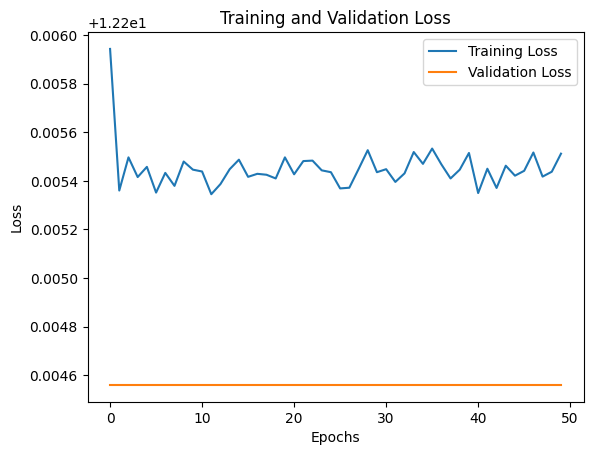

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

18750/18750 [==============================] - 34s 2ms/step - loss: 12.2059 - mean_squared_error: 12.2059
Test Loss: [12.20589828491211, 12.20589828491211]


In [ ]:
predictions = model.predict(X_test)
print(predictions[:])

18750/18750 [==============================] - 29s 2ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [ ]:
accuracy = (predictions == y_test).mean()
print(f'Accuracy: {accuracy}')

NameError: name 'predictions' is not defined

In [ ]:



import pickle
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)
